<a href="https://colab.research.google.com/github/BarathSrinivasan2002/Deep_Learning_Face_mask_detection/blob/main/Supervised_Learning_with_Best_Params.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/BarathSrinivasan2002/Deep_Learning_Face_mask_detection.git

Cloning into 'Deep_Learning_Face_mask_detection'...
remote: Enumerating objects: 1791, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1791 (delta 35), reused 40 (delta 15), pack-reused 1715 (from 2)
Receiving objects: 100% (1791/1791), 402.25 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (870/870), done.


In [2]:
%cd Deep_Learning_Face_mask_detection

/content/Deep_Learning_Face_mask_detection


In [3]:
!ls

 face-mask-detection	       'Supervised_Learning copy.ipynb'
 labels.csv		        Supervised_Learning_Facemask_Detection_CNN.ipynb
 Preprocessing_Pipeline.ipynb   Supervised_Learning.ipynb
 README.md		        Supervised_Learning_with_Best_Params.ipynb
 requirements.txt	        Unsupervised_learning_autoencoders.ipynb
 SOA_Model.ipynb	        Unsupervised_learning_autoencoders.py


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [5]:
# Paths to dataset
ANNOTATION_PATH = '/content/Deep_Learning_Face_mask_detection/face-mask-detection/versions/1/annotations'
IMAGE_PATH = '/content/Deep_Learning_Face_mask_detection/face-mask-detection/versions/1/images'

# Load XML files
xml_files = [os.path.join(ANNOTATION_PATH, f) for f in os.listdir(ANNOTATION_PATH) if f.endswith('.xml')]
data = []
label_pair = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}



In [6]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

def build_pipeline():
    # Step 1: Create a dataframe from XML annotations
    xml_files = [os.path.join(ANNOTATION_PATH, filename)
                 for filename in os.listdir(ANNOTATION_PATH) if filename.endswith('.xml')]
    data = []
    for xml_file in xml_files:
        annotations_tmp = parse_xml(xml_file)
        for ann in annotations_tmp:
            data.append([ann['filename'], ann['label'], ann['bbox']])
    df = pd.DataFrame(data, columns=['filename','label','bbox'])

    # Step 2: Process images into a form ready for model input
    face_images = []
    face_labels = []
    for idx, row in df.iterrows():
        bbox = row['bbox']
        image = cv2.imread(os.path.join(IMAGE_PATH, row['filename']))
        image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
        blurred = cv2.GaussianBlur(image,(9, 9), 10.0)
        alpha = 1.5  # Sharpening factor
        image = cv2.addWeighted(image, 1 + alpha, blurred, -alpha, 0)
        image = cv2.resize(image, (224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

        face_images.append(image)
        face_labels.append(label_pair[row['label']])

    face_images = np.array(face_images, dtype='float32')

    return df, face_images, face_labels

In [7]:
import pickle

# Build the pipeline using the function from cell 1
pipeline_data = {}
pipeline_data['df'], pipeline_data['face_images'], pipeline_data['face_labels'] = build_pipeline()

# Store the pipeline data in a pickle file
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline_data, f)

print("Pipeline stored in pipeline.pkl")

Pipeline stored in pipeline.pkl


In [8]:
# Extract annotations
for xml_file in xml_files:
    annotations = parse_xml(xml_file)
    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

# Create DataFrame
df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
print(df['label'].value_counts())

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64


In [9]:
with open('pipeline.pkl', 'rb') as f:
    pipeline_data = pickle.load(f)
face_images = pipeline_data['face_images']
face_labels = pipeline_data['face_labels']

In [10]:
# Data Augmentation
augmentation = ImageDataGenerator(
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=25,
    fill_mode='nearest'
)

In [11]:

train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, shuffle=True, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, shuffle=True, stratify=test_val_y)

train_y_cat = tf.keras.utils.to_categorical(train_y)
val_y_cat = tf.keras.utils.to_categorical(val_y)
test_y_cat = tf.keras.utils.to_categorical(test_y)

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y_cat.shape, val_y_cat.shape, test_y_cat.shape)

(2850, 224, 224, 3) (611, 224, 224, 3) (611, 224, 224, 3)
(2850, 3) (611, 3) (611, 3)


In [ ]:
%pip install scikeras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Clear backend session to free memory
tf.keras.backend.clear_session()

# Create a function that returns a compiled model
def create_cnn_model(conv_layers=3, filters=[32, 64, 128], dense_neurons=128,
                     dropout_rate=0.5, kernel_size=3, use_batch_norm=False,
                     learning_rate=0.001, optimizer='adam'):
    """
    Function to create a CNN model with configurable hyperparameters
    """
    model = Sequential()

    # Add initial convolutional layer
    model.add(Conv2D(filters[0], (kernel_size, kernel_size), activation='relu',
                    input_shape=(224, 224, 3)))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add additional convolutional layers
    for i in range(1, min(conv_layers, len(filters))):
        model.add(Conv2D(filters[i], (kernel_size, kernel_size), activation='relu'))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add flatten and dense layers
    model.add(Flatten())
    model.add(Dense(dense_neurons, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))

    # Configure optimizer
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = optimizer

    # Compile model
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def manual_grid_search(train_x, train_y, val_x, val_y, param_grid):
    """
    Manually perform grid search for hyperparameter tuning

    Parameters:
    - train_x, train_y: Training data and labels
    - val_x, val_y: Validation data and labels
    - param_grid: Dictionary of hyperparameters to search

    Returns:
    - results_df: DataFrame with all results
    - best_params: Dictionary with best hyperparameters
    - best_model: The best performing model
    """
    results = []
    best_val_accuracy = 0
    best_params = None
    best_model = None

    # Generate all combinations of hyperparameters
    def generate_param_combinations(param_grid, current_combo={}, keys=None, index=0):
        if keys is None:
            keys = list(param_grid.keys())

        if index >= len(keys):
            return [current_combo.copy()]

        combos = []
        for val in param_grid[keys[index]]:
            current_combo[keys[index]] = val
            combos.extend(generate_param_combinations(param_grid, current_combo, keys, index + 1))

        return combos

    # For a more limited search, take a subset of parameter combinations
    param_combinations = generate_param_combinations(param_grid)
    print(f"Total combinations to try: {len(param_combinations)}")

    # Early stopping callback to avoid wasting time on poor models
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    # Try each combination
    for i, params in enumerate(param_combinations):
        print(f"\nTrying combination {i+1}/{len(param_combinations)}: {params}")

        # Create and compile model with current parameters
        model = create_cnn_model(
            conv_layers=params.get('conv_layers', 3),
            filters=params.get('filters', [32, 64, 128])[:params.get('conv_layers', 3)],
            dense_neurons=params.get('dense_neurons', 128),
            dropout_rate=params.get('dropout_rate', 0.5),
            kernel_size=params.get('kernel_size', 3),
            use_batch_norm=params.get('use_batch_norm', False),
            learning_rate=params.get('learning_rate', 0.001),
            optimizer=params.get('optimizer', 'adam')
        )

        # Train the model
        history = model.fit(
            train_x, train_y,
            epochs=params.get('epochs', 10),
            batch_size=params.get('batch_size', 32),
            validation_data=(val_x, val_y),
            callbacks=[early_stopping],
            verbose=1
        )
        val_accuracy = max(history.history['val_accuracy'])
        params_result = params.copy()
        params_result['val_accuracy'] = val_accuracy
        results.append(params_result)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = params.copy()
            best_model = model
        tf.keras.backend.clear_session()

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    print(f"\nBest parameters: {best_params}")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")

    return results_df, best_params, best_model

small_param_grid = {
    'conv_layers': [2, 3],
    'filters': [[32, 64], [32, 64, 128]],
    'dense_neurons': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'use_batch_norm': [True, False],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32],
    'epochs': [5],
    'learning_rate': [0.001, 0.0001]
}


In [ ]:
# Function to evaluate the best model
def evaluate_best_model(model, test_x, test_y):
    """
    Evaluate the best model on test data
    """
    # Make predictions
    y_pred_prob = model.predict(test_x)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(test_y, axis=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Test accuracy
    test_loss, test_accuracy = model.evaluate(test_x, test_y, verbose=0)
    print(f"Test accuracy: {test_accuracy:.4f}")

    return test_accuracy

Total combinations to try: 128

Trying combination 1/128: {'conv_layers': 2, 'filters': [32, 64], 'dense_neurons': 64, 'dropout_rate': 0.3, 'use_batch_norm': True, 'optimizer': 'adam', 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.8350 - loss: 12.9465 - val_accuracy: 0.2537 - val_loss: 28.5375
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8900 - loss: 2.3449 - val_accuracy: 0.4092 - val_loss: 40.4010
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8843 - loss: 2.5521 - val_accuracy: 0.3028 - val_loss: 35.6023
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8232 - loss: 6.6589 - val_accuracy: 0.9133 - val_loss: 0.9192
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8976 - loss: 0.9493 - val_accuracy: 0.9067 - val_loss: 0.9298

Trying combination 2/128: {'conv_layers': 2, 'filters': [32, 64], 'dense_neurons': 64, 'dropout_rate': 0.3, 'use_batch_norm': True, 'optimizer': 'adam', 'batch_size': 32, 'epochs': 5, 'learning_rate': 0.0001}
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8183 - loss: 1.9501 - val_accuracy: 0.0524 - val_loss: 8.4806
Epoch 2/5
90/90 ━━━━━━━━━━━━━

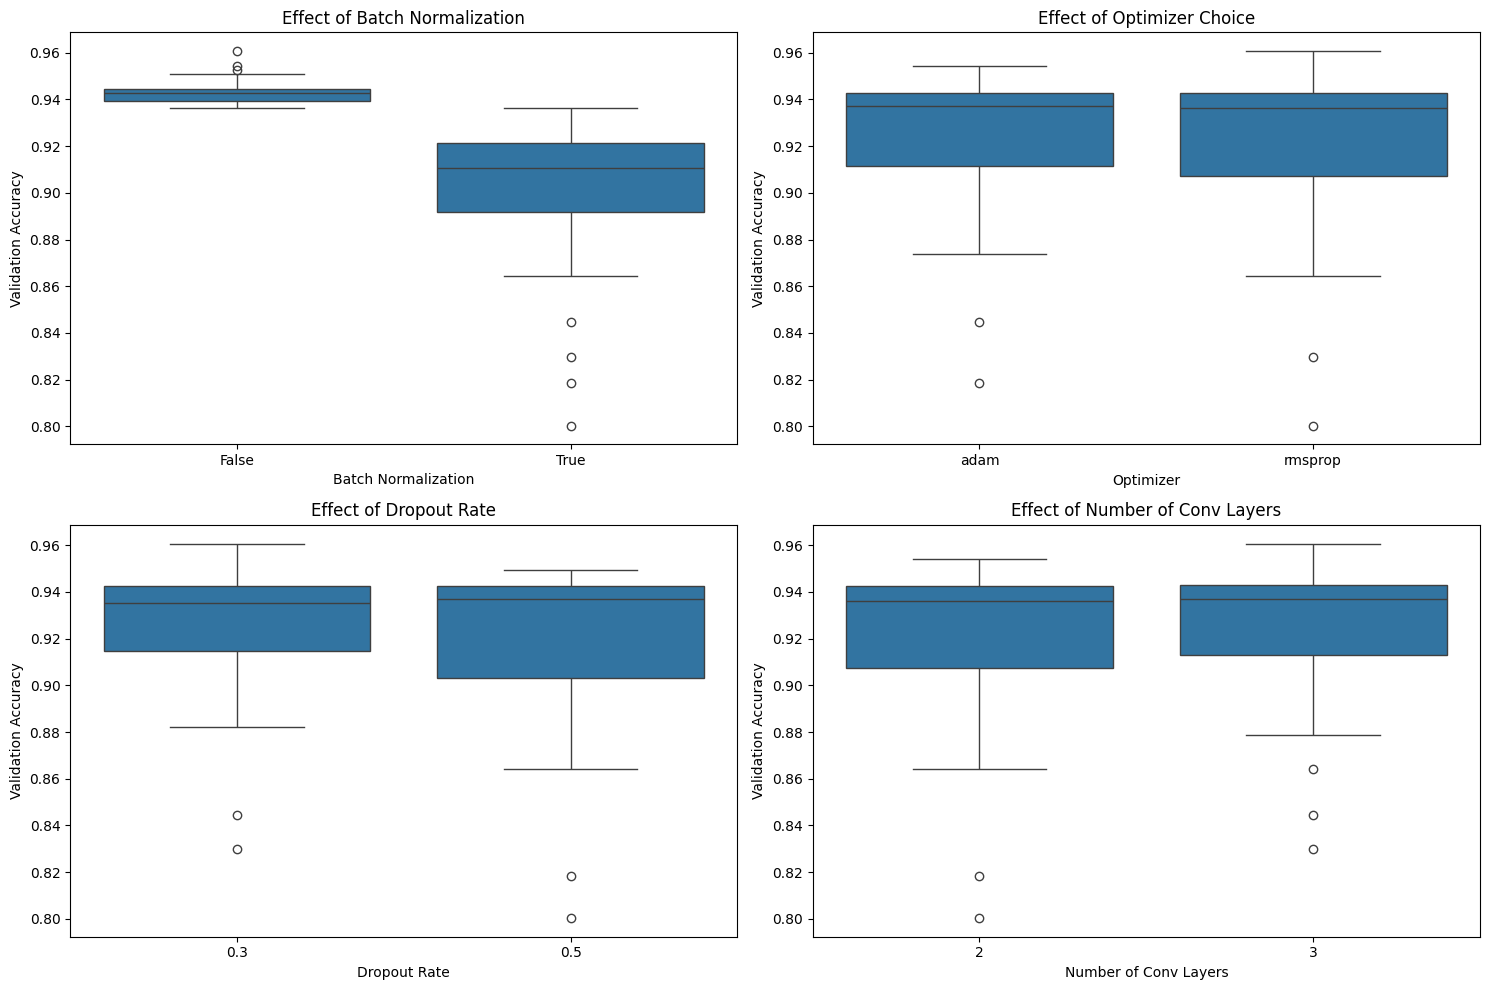

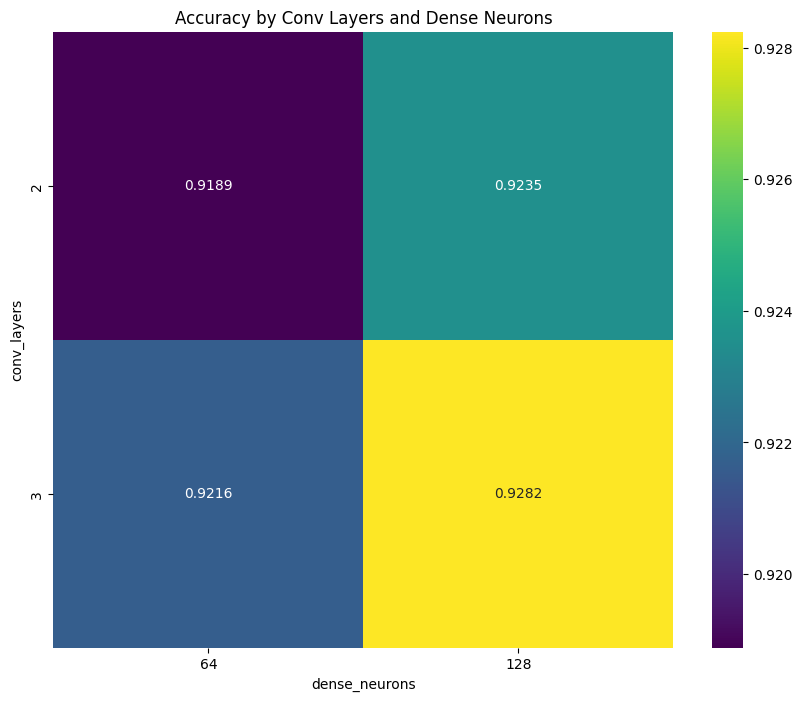

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       485
           1       0.91      0.96      0.94       107
           2       0.67      0.21      0.32        19

    accuracy                           0.95       611
   macro avg       0.85      0.72      0.74       611
weighted avg       0.95      0.95      0.95       611



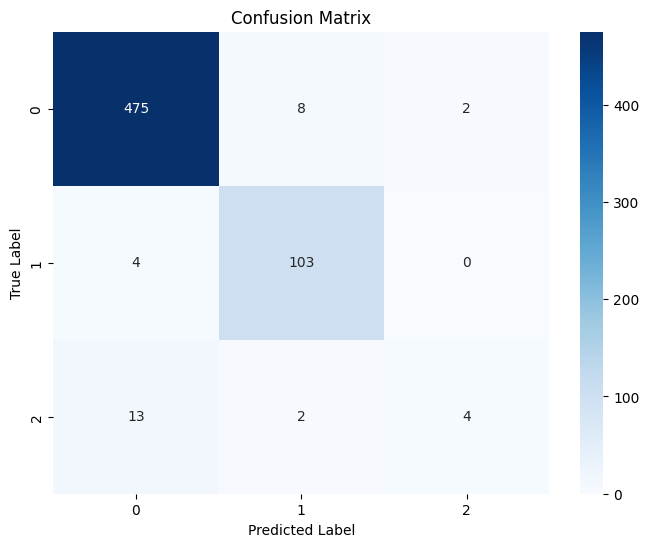

Test accuracy: 0.9525


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,338,696 (85.22 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,169,349 (42.61 MB)

In [ ]:
results_df, best_params, best_model = manual_grid_search(
    train_x, train_y, val_x, val_y, small_param_grid
)

# Evaluate the best model
evaluate_best_model(best_model, test_x, test_y)

# Save the best model
best_model.save('best_cnn_model.h5')

# Print the architecture of the best model
best_model.summary()

In [12]:
#Model with Best Parameters

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.fit(train_x, train_y_cat, epochs=10, batch_size=32, validation_data=(val_x, val_y_cat))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.8185 - loss: 1.3680 - val_accuracy: 0.9444 - val_loss: 0.1998
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9291 - loss: 0.2222 - val_accuracy: 0.9444 - val_loss: 0.1757
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9366 - loss: 0.1900 - val_accuracy: 0.9394 - val_loss: 0.2225
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9505 - loss: 0.1801 - val_accuracy: 0.9493 - val_loss: 0.1560
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9571 - loss: 0.1390 - val_accuracy: 0.9525 - val_loss: 0.1823
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9617 - loss: 0.1035 - val_accuracy: 0.9542 - val_loss: 0.2058
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9730 - loss: 0.0978 - val_accuracy: 0.9460 - val_loss: 0.2624
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9731 - loss: 0.0840 - val_accuracy: 0.9476 - 

In [14]:
predictions = model.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_y

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [16]:

# Calculate the number of correct predictions and compute accuracy
accuracy = np.sum(predicted_labels == true_labels) / float(len(true_labels))
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9492635024549918


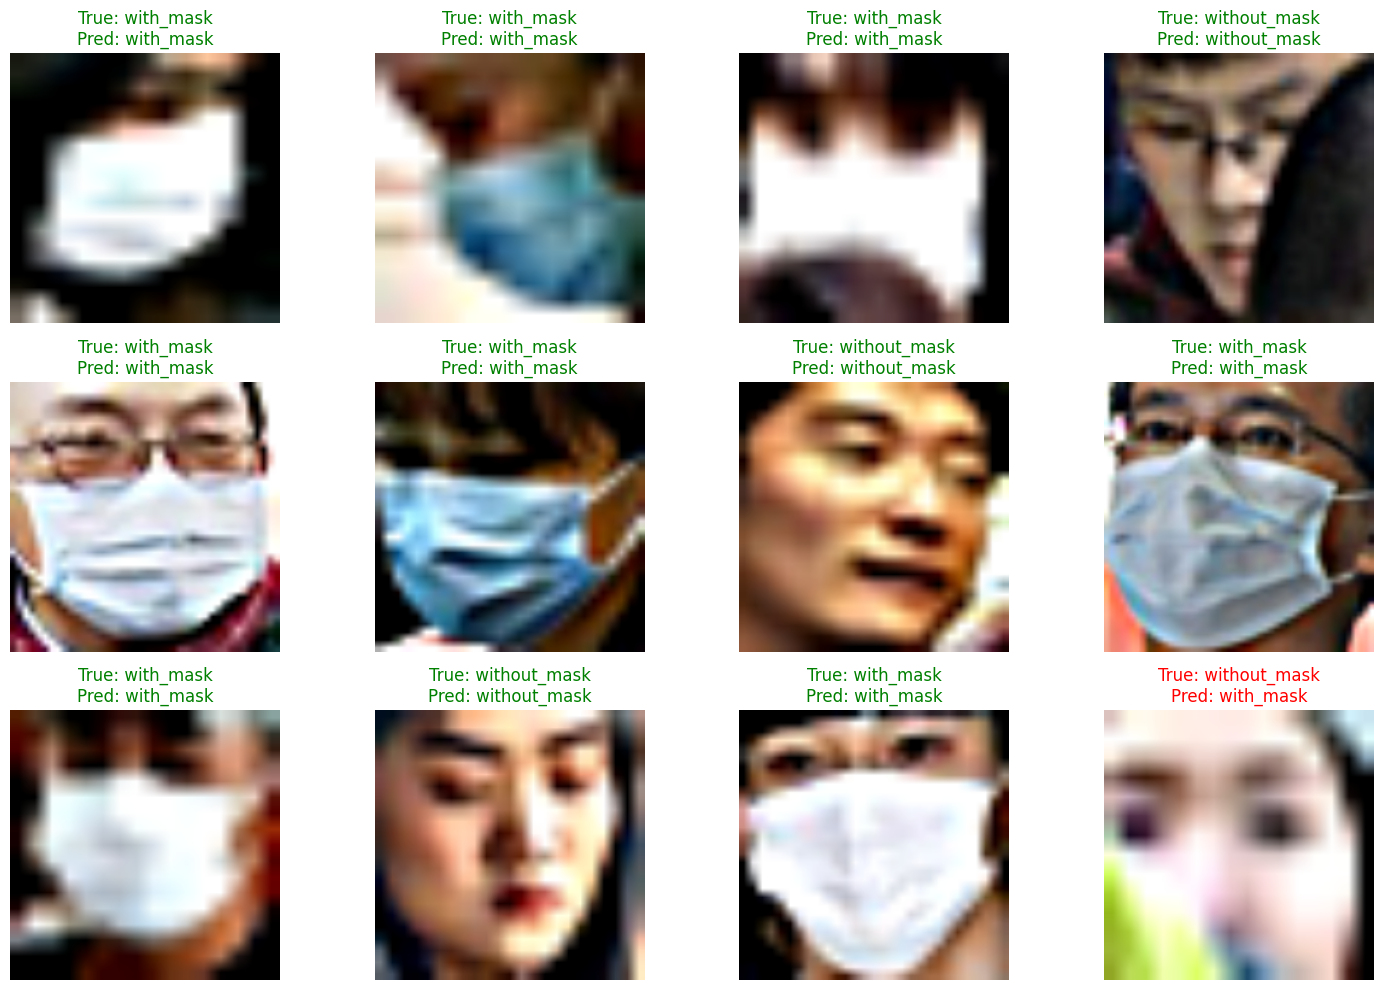

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Create a mapping from numeric labels back to string labels
label_mapping = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}

# Select 12 random indices from the test set
random_indices = np.random.choice(len(test_x), 12, replace=False)

# Plot a grid of 12 random images with their predictions
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 4, i+1)
    # Convert image from normalized [-1, 1] to uint8 and BGR to RGB
    plt.imshow(cv2.cvtColor(((test_x[idx] + 1) * 127.5).astype(np.uint8), cv2.COLOR_BGR2RGB))

    true_label = label_mapping[true_labels[idx]]
    pred_label = label_mapping[predicted_labels[idx]]
    color = 'green' if true_labels[idx] == predicted_labels[idx] else 'red'

    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()
